In [73]:
from keras.models import load_model
import matplotlib.pyplot as plt
from utils import *
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3,preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import urllib
import cv2
from keras.preprocessing import image
from keras.models import load_model
%matplotlib inline
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.backend import categorical_crossentropy

In [266]:
def _fgsm(x, predictions, eps, clip_min=None, clip_max=None, towards=False):
    """
    TensorFlow implementation of the Fast Gradient
    Sign method.
    :param x: the input placeholder
    :param predictions: the model's output tensor
    :param eps: the epsilon (input variation parameter)
    :param clip_min: optional parameter that can be used to set a minimum
                    value for components of the example returned
    :param clip_max: optional parameter that can be used to set a maximum
                    value for components of the example returned
    :return: a tensor for the adversarial example
    """
    # Compute loss
    y = tf.to_float(
        tf.equal(predictions, tf.reduce_max(predictions, 1, keep_dims=True)))
    
    loss = model_loss(y, predictions)
    # Define gradient of loss wrt input
    grad, = tf.gradients(loss, x)

    # Take sign of gradient
    signed_grad = tf.sign(grad)

    # Multiply by constant epsilon
    scaled_signed_grad = eps * signed_grad
    if towards:
        # Add perturbation to original example to obtain adversarial example
        adv_x = tf.stop_gradient(x - scaled_signed_grad)
    else:
        adv_x = tf.stop_gradient(x + scaled_signed_grad)

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) and (clip_max is not None):
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    return adv_x

In [267]:
def fgsm(sess, model, img, softmax_predictions, eps=0.9,towards=False):
    images_placeholder = tf.placeholder(tf.float32, shape=model.input_shape)
    predictions_placeholder = model(images_placeholder)
    adv_x = _fgsm(images_placeholder, predictions_placeholder, eps=eps, towards=towards)
    with sess.as_default():
        feed_dict = dict()
        feed_dict[K.learning_phase()] = 0
        feed_dict[images_placeholder] = img
        feed_dict[predictions_placeholder] = softmax_predictions
        res = sess.run([adv_x],feed_dict=feed_dict)
    return res

In [268]:
def fgsm_iter(sess, model, img, softmax_predictions, n_steps=10, eps=0.9, towards=False):

    images_placeholder = tf.placeholder(tf.float32, shape=model.input_shape)
    predictions_placeholder = model(images_placeholder)
    adv_x = _fgsm(images_placeholder, predictions_placeholder, eps=eps, towards=towards)
    with sess.as_default():
        for ix in range(n_steps):
            img_input = img if ix == 0 else res[0]
            feed_dict = dict()
            feed_dict[K.learning_phase()] = 0
            feed_dict[images_placeholder] = img_input
            feed_dict[predictions_placeholder] = softmax_predictions
            res = sess.run([adv_x], feed_dict=feed_dict)
    return res

In [269]:
def model_loss(y, model, mean=True):
    """
    Define loss of TF graph
    :param y: correct labels
    :param model: output of the model
    :param mean: boolean indicating whether should return mean of loss
                 or vector of losses for each input of the batch
    :return: return mean of loss if True, otherwise return vector with per
             sample loss
    """

    op = model.op
    if "softmax" in str(op).lower():
        logits, = op.inputs
    else:
        logits = model

    out = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

    if mean:
        out = tf.reduce_mean(out)
    return out

In [270]:
sess = K.get_session()
keras.backend.set_session(sess)

In [271]:
img = image.load_img("panda.JPG", target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

In [272]:
black = np.zeros_like(img)

In [273]:
# model = InceptionV3(include_top=True,weights='imagenet')
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [274]:
model = VGG16(weights='imagenet')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [281]:
desired_predictions = np.zeros(shape=(1,1000))
desired_predictions[0][233] = 1

In [282]:
# loss = tf.reduce_mean(K.categorical_crossentropy(labels_placeholder,predictions))
# grad, = tf.gradients(loss,images_placeholder)
# signed_grad = tf.sign(grad)
# scaled_signed_grad = 0.9 * signed_grad
# adv_x = tf.stop_gradient(images_placeholder + scaled_signed_grad)

In [286]:
res = fgsm_iter(sess, model, img, desired_predictions,towards=False, eps=0.07, n_steps=10)

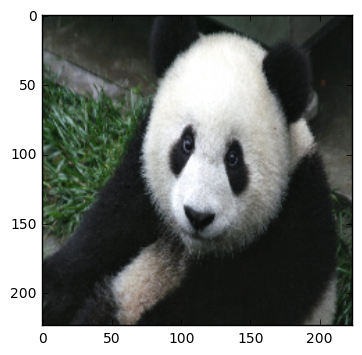

In [287]:
adv = Image.fromarray(res[0][0].astype('uint8'),'RGB')
plt.imshow(adv)

In [288]:
decode_predictions(model.predict(res[0]),top=10)

[[(u'n02510455', u'giant_panda', 0.99993801),
  (u'n02134084', u'ice_bear', 2.9209734e-05),
  (u'n02488702', u'colobus', 1.1545354e-05),
  (u'n02509815', u'lesser_panda', 9.491444e-06),
  (u'n02120079', u'Arctic_fox', 6.1196979e-06),
  (u'n02443114', u'polecat', 1.0517134e-06),
  (u'n02441942', u'weasel', 9.6242434e-07),
  (u'n02483362', u'gibbon', 8.4865803e-07),
  (u'n02444819', u'otter', 6.0346565e-07),
  (u'n02447366', u'badger', 3.7405556e-07)]]

In [289]:
decode_predictions(model.predict(img),top=5)

[[(u'n02510455', u'giant_panda', 0.67758793),
  (u'n02120079', u'Arctic_fox', 0.036715165),
  (u'n02134084', u'ice_bear', 0.035375513),
  (u'n04399382', u'teddy', 0.029222358),
  (u'n02111889', u'Samoyed', 0.02467075)]]